In [ ]:
install.packages("gtools")
install.packages("plyr")
install.packages("anytime")
install.packages("ggplot2")
install.packages("httr")
install.packages("jsonlite")
install.packages("ggpubr")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘matrixStats’, ‘RcppArmadillo’, ‘numDeriv’, ‘SparseM’, ‘MatrixModels’, ‘conquer’, ‘sp’, ‘data.table’, ‘openxlsx’, ‘minqa’, ‘nloptr’, ‘statmod’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘pbkrtest’, ‘quantreg’, ‘maptools’, ‘rio’, ‘lme4’, ‘corrplot’, ‘car’, ‘ggrepel’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘gridExtra’, ‘polynom’, ‘rstatix’




In [ ]:
library(jsonlite)
library(dplyr)
library(httr)
library(tibble)
library(ggplot2)

#this function creates an access token from the blizzard api
createAccessToken <- function(apiKey, apiSecret, region = "us") 
{
  response <- POST(
    paste("https://", region, ".battle.net/oauth/token", sep = ""),
    authenticate(apiKey, apiSecret),
    body = list(grant_type="client_credentials")
  )
  return(fromJSON(content(response, "text"), flatten = TRUE))
}

In [ ]:
#this function creates a token for the users developer ID and Secret obtained from the blizzard developer page.
newtoken<-function(){
mykey<-readline(prompt = "Enter Blizzard API Key: ")
mysecret<-readline(prompt="Enter Blizzard API Secret: ")
mytoken<-createAccessToken(mykey,mysecret)
quck<-as.data.frame(mytoken)
head(quck)
token<-quck[1,1]
return(token)
}

In [ ]:
#this overall function creates the Legal Tender guild roster with information from the character summary endpoint from the Blizzard API

roster1<-function(token){
require(plyr)
require(dplyr)
require(gtools)
require(anytime)
#this gets the most up to date guild roster  
x<-paste("https://us.api.blizzard.com/data/wow/guild/lightbringer/legal-tender/roster?namespace=profile-us&locale=en_US&access_token=", token, sep="")
gr<-httr::GET(x)
fix<-content(gr, as="text", encoding = "UTF-8")
new<-fromJSON(fix)
content<-as_data_frame(new$members)
df<-as.data.frame(content$character)
roster<-df[,c(2,3)]
  
#this takes the names from the guild roster and iterates through them and provides a dataframe that includes updated player information from the API
dftotal<-data.frame()
for (i in roster$name){
x<-paste("https://us.api.blizzard.com/profile/wow/character/lightbringer/", URLencode(tolower(i)), "?namespace=profile-us&locale=en_US&access_token=",token, sep="")
stuff<-httr::GET(x)
fix<-content(stuff, as="text")
new<-fromJSON(fix)
df<-as.data.frame(new)
dftotal<-rbind.fill(dftotal, df)}
roster2<-dftotal[,c("name", "level","gender.name", "race.name", "character_class.name", "active_spec.name", "experience", "achievement_points", "last_login_timestamp", "equipped_item_level", "active_title.name", "covenant_progress.chosen_covenant.name","covenant_progress.renown_level")]
roster3<-roster2[!is.na(roster2$name),]
roster3$last_login_timestamp<-anydate(roster3$last_login_timestamp/1000)
time<-as.Date(Sys.Date())
roster3$days.since.last.online<-difftime(as.POSIXct(time), as.POSIXct(roster3$last_login_timestamp), units="days")
return(roster3)
}

In [ ]:
#this creates a function to pull in cleaned professions data
require(plyr)
require(dplyr)
require(gtools)
professions<-function(x, token){
  dftotal<-data.frame()
  for (i in x){
  y<-paste("https://us.api.blizzard.com/profile/wow/character/lightbringer/", URLencode(tolower(i)), "/professions?namespace=profile-us&locale=en_US&access_token=",token, sep="")
  grab<-httr::GET(y)
  stuff1<-content(grab, as="text")
  stuff2<-fromJSON(stuff1)
  testbed1<-as_data_frame(stuff2$primaries)
  tibby<-as_tibble(testbed1)
  z<-enframe(unlist(tibby))
    if (any(z$name=="profession.name")){
      a<-z[2,2]
      b<-NA}
    else{
      a<-z[3,2]
      b<-z[4,2]}
  df<-data.frame(i, a, b)
  names(df)<-names(dftotal)
  dftotal<-rbind(dftotal, df)}
  colnames(dftotal)<-c("name", "profession.1", "profession.2")
 return (dftotal)
}

Loading required package: plyr

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


Loading required package: gtools



In [ ]:
#this is the function that merges the data frames into useable content.
updateguilddata<-function(){
  token<-newtoken()
  x<-roster1(token)
  y<-professions(x$name,token)
  z<-merge(x, y, by="name")
  return(z)
}

The code below generates a new guild roster for Legal Tender. Note that you will need to enter a Blizzard API key and Secret. You must create an account for this. This process will take a while as the guild is currently maxed at nearly 1,000 characters.

In [ ]:
newroster<-updateguilddata()

Enter Blizzard API Key: d85a7c64fafb4e4db16006aee1c6a882
Enter Blizzard API Secret: Lokm5AxOpDEQ8AMkKTG2OTFbJCFCEnvh


Loading required package: anytime

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
Warning message:
“`as_data_frame()` is deprecated as of tibble 2.0.0.
Please use `as_tibble()` instead.
The signature and semantics have changed, see `?as_tibble`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”
Warning message:
“The `i` argument of ``[.tbl_df`()` must lie in [0, rows] if positive, as of tibble 3.0.0.
Use `NA_integer_` as row index to obtain a row full of `NA` values.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


In [ ]:
head(newroster)

,name,level,gender.name,race.name,character_class.name,active_spec.name,experience,achievement_points,last_login_timestamp,equipped_item_level,active_title.name,covenant_progress.chosen_covenant.name,covenant_progress.renown_level,days.since.last.online,profession.1,profession.2
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<date>,<int>,<chr>,<chr>,<int>,<drtn>,<chr>,<chr>
1,Aakiira,50,Female,Mag'har Orc,Shaman,Enhancement,0,14815,2020-08-02,410,of the Frostwolves,NA,NA,171 days,Alchemy,Herbalism
2,Acinin,60,Male,Blood Elf,Paladin,Retribution,0,15710,2020-12-10,156,of the Ashen Verdict,Venthyr,3,41 days,Mining,Jewelcrafting
3,Adanac,50,Male,Troll,Shaman,Elemental,0,9565,2020-10-27,78,NA,NA,NA,85 days,Alchemy,Herbalism
4,Adokk,50,Male,Orc,Death Knight,Blood,0,14700,2020-11-17,98,the Fearless,NA,NA,64 days,NA,NA
5,Aenstolan,47,Male,Blood Elf,Demon Hunter,Havoc,129994,345,2020-11-27,54,Illidari,NA,NA,54 days,NA,NA
6,Aeralith,60,Female,Troll,Warlock,Destruction,0,15775,2020-12-16,165,NA,Kyrian,8,35 days,NA,NA


In [ ]:
str(newroster)

'data.frame':	926 obs. of  16 variables:
 $ name                                  : chr  "Aakiira" "Acinin" "Adanac" "Adokk" ...
 $ level                                 : int  50 60 50 50 47 60 50 60 60 50 ...
 $ gender.name                           : chr  "Female" "Male" "Male" "Male" ...
 $ race.name                             : chr  "Mag'har Orc" "Blood Elf" "Troll" "Orc" ...
 $ character_class.name                  : chr  "Shaman" "Paladin" "Shaman" "Death Knight" ...
 $ active_spec.name                      : chr  "Enhancement" "Retribution" "Elemental" "Blood" ...
 $ experience                            : int  0 0 0 0 129994 0 0 0 0 0 ...
 $ achievement_points                    : int  14815 15710 9565 14700 345 15775 4680 7180 8635 13065 ...
 $ last_login_timestamp                  : Date, format: "2020-08-02" "2020-12-10" ...
 $ equipped_item_level                   : int  410 156 78 98 54 165 396 182 141 80 ...
 $ active_title.name                     : chr  "of the Frostw

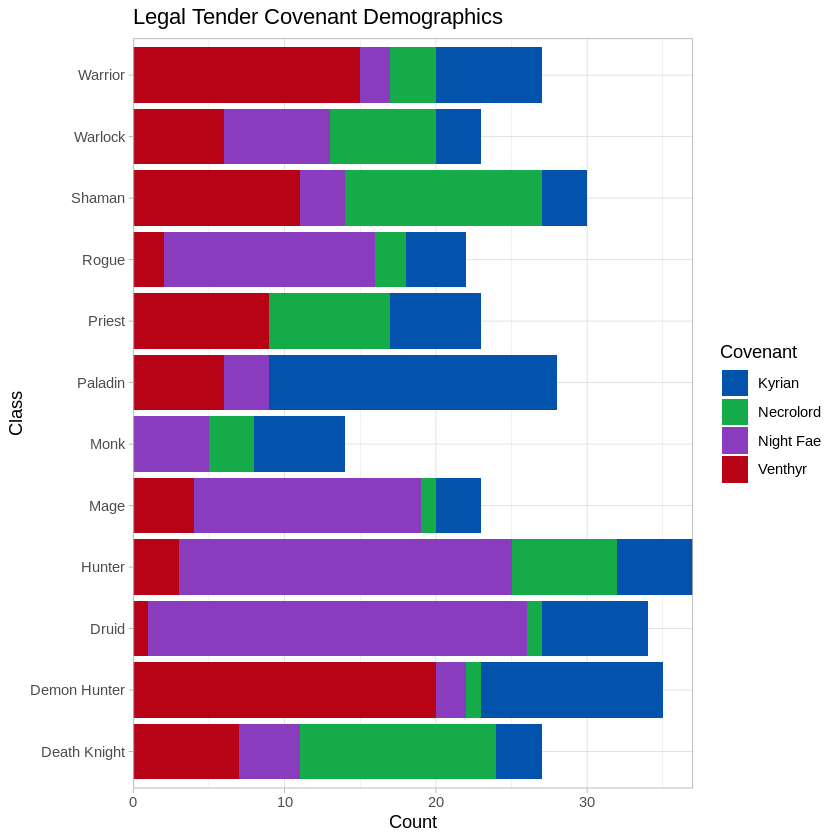

In [ ]:
library(ggplot2)
things<-table(newroster$character_class.name, newroster$covenant_progress.chosen_covenant.name)
things<-as.data.frame(things)
myplot<-ggplot(data=things, aes(x=Var1, y=Freq, fill=Var2))+geom_bar(stat="identity",position  ="stack")+coord_flip()+scale_fill_manual(values=c("#0352AB", "#15AB49", "#893DBE", "#B80216"))+ggtitle("Legal Tender Covenant Demographics")+xlab("Class")+ylab("Count")+theme_light()+labs(fill="Covenant")+scale_y_continuous(expand=c(0,0))
myplot

Noting that after one character has achieved max level, new characters on the same account may select a covenant after level 50, there is clearly some disparity among the demographics. Monk population is low in Shadowlands while Hunters and Demon Hunters remain high. Also note that Priests do not typically select Nigh Fae as a a Covenant nor do Monks select Venthyr. Hunters, Magi, and Druids are overwhelmingly partial to Night Fae and Demon Hunters, Paladins to Kyrian, and Demon Hunters to Venthyr. Overall there appears to be balance although not among each class individually. 

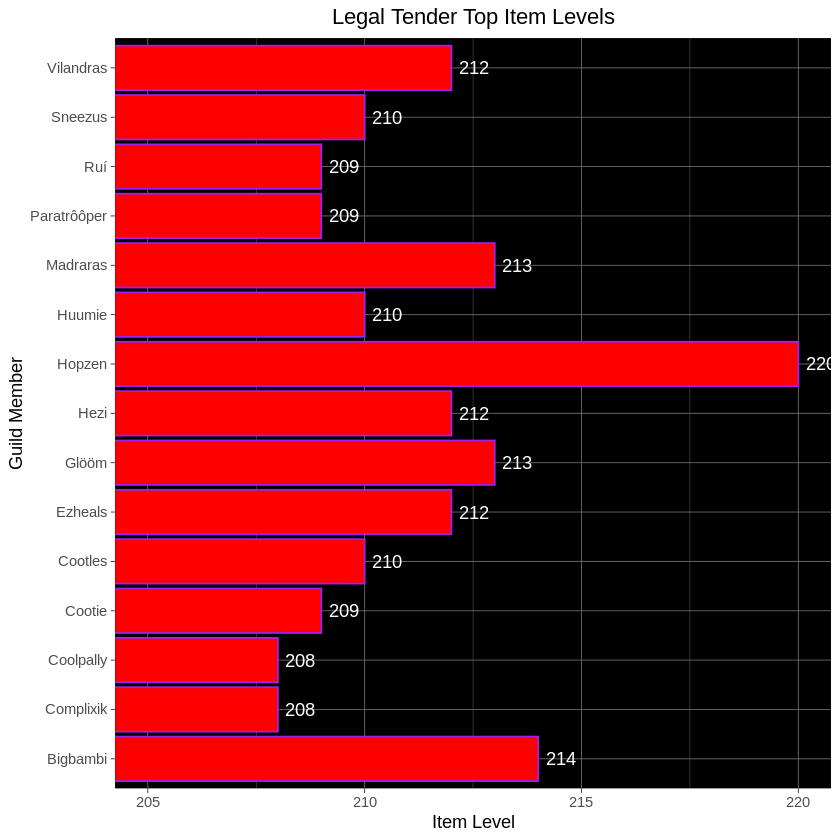

In [ ]:
sixty<-newroster[which(newroster$level==60),]
orderme<-(sixty[order(-sixty$equipped_item_level),])
top<-head(orderme, n=15)
snakes<-ggplot(data=top, aes(x=name, y=equipped_item_level, fill=name))+geom_bar(stat="identity", position='dodge', fill="red", color="purple")+theme_dark()+theme(legend.position="none")+theme(panel.background=element_rect(fill="black", colour="black"))+ggtitle("Legal Tender Top Item Levels")+xlab("Guild Member")+ylab("Item Level")+theme(plot.title=element_text(hjust=0.5))+geom_text(aes(label=equipped_item_level), position=position_dodge(1), vjust=.50, hjust=-.25, color="white")+coord_flip(ylim=c(205,220))
snakes

This is a simple chart demonstrating the highest achievement levels in the guild for our max level members.

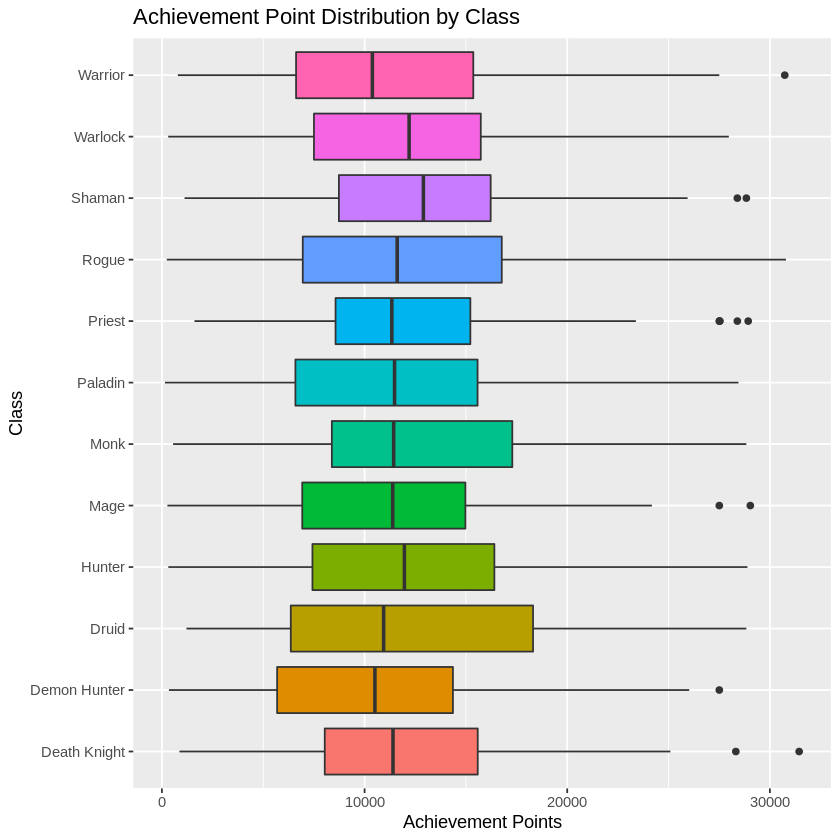

In [ ]:
boxplot1<-ggplot(newroster, aes(y=achievement_points, x=character_class.name, fill=character_class.name))+geom_boxplot()+coord_flip()+theme(legend.position="none")+ggtitle("Achievement Point Distribution by Class")+ylab("Achievement Points")+xlab("Class")
boxplot1


This is a Box Plot breakdown of Achievment Points. For the most part it appears that all classes within the guild perform similarly in collecting achievement points. There does not appear to be any individual class that holds advantage

In [ ]:
chart<-function(class){
  x<-subset(newroster,character_class.name==class)
  y<-as.data.frame(table(x$character_class.name, x$active_spec.name))
  return(y)
}


for(i in unique(newroster$character_class.name)){
  nam<-paste("df", i, sep=".")
  assign(nam, chart(i))
}

In [ ]:
Dru<-ggplot(data=df.Druid, aes(x=Var2, y=Freq, fill=Var2))+geom_bar(stat="identity", position='dodge', fill="#FF7C0A", color="white", size=1)+theme_dark()+theme(legend.position="none")+theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank(), panel.background = element_rect(fill="black"), axis.line=element_line(colour="black"))+xlab("Spec")+ylab("Count")+theme(plot.title=element_text(hjust=0.5))+geom_text(aes(label=Freq), position=position_dodge(1), vjust=-.50, hjust=.50, color="white")+scale_y_continuous(expand=c(0,0))+coord_cartesian(ylim=c(0,75))+facet_wrap(~Var1)
Dea<-ggplot(data=`df.Death Knight`, aes(x=Var2, y=Freq, fill=Var2))+geom_bar(stat="identity", position='dodge', fill="#C41E3A", color="white", size=1)+theme_dark()+theme(legend.position="none")+theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank(), panel.background = element_rect(fill="black"), axis.line=element_line(colour="black"))+xlab("Spec")+ylab("Count")+theme(plot.title=element_text(hjust=0.5))+geom_text(aes(label=Freq), position=position_dodge(1), vjust=-.50, hjust=.50, color="white")+scale_y_continuous(expand=c(0,0))+coord_cartesian(ylim=c(0,75))+facet_wrap(~Var1)
Hun<-ggplot(data=df.Hunter, aes(x=Var2, y=Freq, fill=Var2))+geom_bar(stat="identity", position='dodge', fill="#AAD372", color="white", size=1)+theme_dark()+theme(legend.position="none")+theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank(), panel.background = element_rect(fill="black"), axis.line=element_line(colour="black"))+xlab("Spec")+ylab("Count")+theme(plot.title=element_text(hjust=0.5))+geom_text(aes(label=Freq), position=position_dodge(1), vjust=-.50, hjust=.50, color="white")+scale_y_continuous(expand=c(0,0))+coord_cartesian(ylim=c(0,75))+facet_wrap(~Var1)
Demon<-ggplot(data=`df.Demon Hunter`, aes(x=Var2, y=Freq, fill=Var2))+geom_bar(stat="identity", position='dodge', fill="#A330C9", color="white", size=1)+theme_dark()+theme(legend.position="none")+theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank(), panel.background = element_rect(fill="black"), axis.line=element_line(colour="black"))+xlab("Spec")+ylab("Count")+theme(plot.title=element_text(hjust=0.5))+geom_text(aes(label=Freq), position=position_dodge(1), vjust=-.50, hjust=.50, color="white")+scale_y_continuous(expand=c(0,0))+coord_cartesian(ylim=c(0,75))+facet_wrap(~Var1)
Magi<-ggplot(data=df.Mage, aes(x=Var2, y=Freq, fill=Var2))+geom_bar(stat="identity", position='dodge', fill="#3FC7EB", color="white", size=1)+theme_dark()+theme(legend.position="none")+theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank(), panel.background = element_rect(fill="black"), axis.line=element_line(colour="black"))+xlab("Spec")+ylab("Count")+theme(plot.title=element_text(hjust=0.5))+geom_text(aes(label=Freq), position=position_dodge(1), vjust=-.50, hjust=.50, color="white")+scale_y_continuous(expand=c(0,0))+coord_cartesian(ylim=c(0,75))+facet_wrap(~Var1)
Monk<-ggplot(data=df.Monk, aes(x=Var2, y=Freq, fill=Var2))+geom_bar(stat="identity", position='dodge', fill="#00FF98", color="white", size=1)+theme_dark()+theme(legend.position="none")+theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank(), panel.background = element_rect(fill="black"), axis.line=element_line(colour="black"))+xlab("Spec")+ylab("Count")+theme(plot.title=element_text(hjust=0.5))+geom_text(aes(label=Freq), position=position_dodge(1), vjust=-.50, hjust=.50, color="white")+scale_y_continuous(expand=c(0,0))+coord_cartesian(ylim=c(0,75))+facet_wrap(~Var1)
Pally<-ggplot(data=df.Paladin, aes(x=Var2, y=Freq, fill=Var2))+geom_bar(stat="identity", position='dodge', fill="#F48CBA", color="white", size=1)+theme_dark()+theme(legend.position="none")+theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank(), panel.background = element_rect(fill="black"), axis.line=element_line(colour="black"))+xlab("Spec")+ylab("Count")+theme(plot.title=element_text(hjust=0.5))+geom_text(aes(label=Freq), position=position_dodge(1), vjust=-.50, hjust=.50, color="white")+scale_y_continuous(expand=c(0,0))+coord_cartesian(ylim=c(0,75))+facet_wrap(~Var1)
Priest<-ggplot(data=df.Priest, aes(x=Var2, y=Freq, fill=Var2))+geom_bar(stat="identity", position='dodge', fill="#FFFFFF", color="white", size=1)+theme_dark()+theme(legend.position="none")+theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank(), panel.background = element_rect(fill="black"), axis.line=element_line(colour="black"))+xlab("Spec")+ylab("Count")+theme(plot.title=element_text(hjust=0.5))+geom_text(aes(label=Freq), position=position_dodge(1), vjust=-.50, hjust=.50, color="white")+scale_y_continuous(expand=c(0,0))+coord_cartesian(ylim=c(0,75))+facet_wrap(~Var1)
Rogue<-ggplot(data=df.Rogue, aes(x=Var2, y=Freq, fill=Var2))+geom_bar(stat="identity", position='dodge', fill="#FFF468", color="white", size=1)+theme_dark()+theme(legend.position="none")+theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank(), panel.background = element_rect(fill="black"), axis.line=element_line(colour="black"))+xlab("Spec")+ylab("Count")+theme(plot.title=element_text(hjust=0.5))+geom_text(aes(label=Freq), position=position_dodge(1), vjust=-.50, hjust=.50, color="white")+scale_y_continuous(expand=c(0,0))+coord_cartesian(ylim=c(0,75))+facet_wrap(~Var1)
Shammy<-ggplot(data=df.Shaman, aes(x=Var2, y=Freq, fill=Var2))+geom_bar(stat="identity", position='dodge', fill="#0070DD", color="white", size=1)+theme_dark()+theme(legend.position="none")+theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank(), panel.background = element_rect(fill="black"), axis.line=element_line(colour="black"))+xlab("Spec")+ylab("Count")+theme(plot.title=element_text(hjust=0.5))+geom_text(aes(label=Freq), position=position_dodge(1), vjust=-.50, hjust=.50, color="white")+scale_y_continuous(expand=c(0,0))+coord_cartesian(ylim=c(0,75))+facet_wrap(~Var1)
Lock<-ggplot(data=df.Warlock, aes(x=Var2, y=Freq, fill=Var2))+geom_bar(stat="identity", position='dodge', fill="#8788EE", color="white", size=1)+theme_dark()+theme(legend.position="none")+theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank(), panel.background = element_rect(fill="black"), axis.line=element_line(colour="black"))+xlab("Spec")+ylab("Count")+theme(plot.title=element_text(hjust=0.5))+geom_text(aes(label=Freq), position=position_dodge(1), vjust=-.50, hjust=.50, color="white")+scale_y_continuous(expand=c(0,0))+coord_cartesian(ylim=c(0,75))+facet_wrap(~Var1)
War<-ggplot(data=df.Warrior, aes(x=Var2, y=Freq, fill=Var2))+geom_bar(stat="identity", position='dodge', fill="#C69B6D", color="white", size=1)+theme_dark()+theme(legend.position="none")+theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank(), panel.background = element_rect(fill="black"), axis.line=element_line(colour="black"))+xlab("Spec")+ylab("Count")+theme(plot.title=element_text(hjust=0.5))+geom_text(aes(label=Freq), position=position_dodge(1), vjust=-.50, hjust=.50, color="white")+scale_y_continuous(expand=c(0,0))+coord_cartesian(ylim=c(0,75))+facet_wrap(~Var1)


The below code merges the above bar charts into one chart that demonstrates the demographics for the guild by current class specialization selected at the moment the data was pulled. It will be hard to view in the preview so this code creates a jpg in the files section as well.

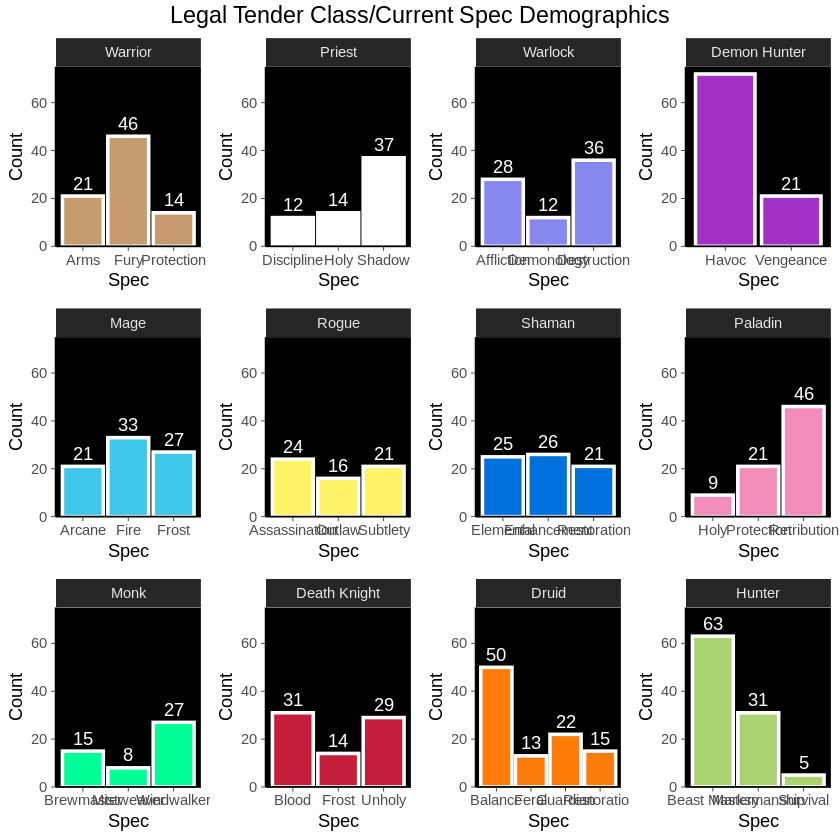

In [ ]:
library(ggpubr)
figure<-ggarrange(War, Priest, Lock, Demon, Magi, Rogue, Shammy, Pally, Monk, Dea, Dru, Hun,  ncol=4, nrow=3)
this<-annotate_figure(figure, top=text_grob("Legal Tender Class/Current Spec Demographics", color="black", size=14))
ggsave("figure.jpg", this, width=4, height=3, scale=4)
this